# Test simple RNN, LSTM and GRU models

### load data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import re
import sys

import tensorflow as tf
import tensorflow.keras as K

from tensorflow.keras.utils import plot_model
from utils import get_train_data

2021-12-30 17:38:56.119414: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
if sys.platform == "linux":
    physical_devices = tf.config.experimental.list_physical_devices("GPU")
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)

2021-12-30 17:38:58.609869: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-12-30 17:38:59.579696: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2021-12-30 17:38:59.579759: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: andrew-Aspire-A715-41G
2021-12-30 17:38:59.579772: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: andrew-Aspire-A715-41G
2021-12-30 17:38:59.580018: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.86.0
2021-12-30 17:38:59.580059: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.86.0
2021-12-30 17:38:59.580071: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.86.0


In [3]:
X_train, y_train = get_train_data()

id1_hook_2 reversed: False data shape: (792, 36)
--------------------
id3_hook_1 reversed: False data shape: (1461, 36)
--------------------
id3_hook_2 reversed: False data shape: (1297, 36)
--------------------
id4_hook_1 reversed: False data shape: (1054, 36)
--------------------
id4_hook_2 reversed: False data shape: (1059, 36)
--------------------
id1_hook_1 reversed: False data shape: (858, 36)
--------------------
id2_hook_1 reversed: False data shape: (1013, 36)
--------------------
id0_hook_2 reversed: False data shape: (1051, 36)
--------------------
id0_hook_1 reversed: False data shape: (1100, 36)
--------------------
id2_hook_2 reversed: False data shape: (1041, 36)
--------------------
id3_jab_2 reversed: False data shape: (1164, 36)
--------------------
id4_jab_1 reversed: False data shape: (911, 36)
--------------------
id2_jab_1 reversed: False data shape: (1032, 36)
--------------------
id0_jab_1 reversed: False data shape: (952, 36)
--------------------
id0_jab_2 reve

In [4]:
TIME_STEPS = 30 # expect camera 30 fps, so process 1 sample per second

# Number of samples in batch
N_train = X_train.shape[0] // TIME_STEPS 

X_train = X_train[:N_train * TIME_STEPS].reshape(-1, TIME_STEPS, 36)
y_train = y_train[:N_train * TIME_STEPS].reshape(-1, TIME_STEPS, 1)

In [5]:
y_train = K.utils.to_categorical(y_train, num_classes=7)
X_train = tf.constant(X_train)

2021-12-30 17:39:03.051689: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-30 17:39:03.085407: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2295760000 Hz
2021-12-30 17:39:03.086460: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2f96c70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-12-30 17:39:03.086515: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


## Simple RNN 

In [6]:
def get_model():
    return K.Sequential([
        K.layers.InputLayer((30, 36), batch_size=1),
        K.layers.SimpleRNN(64, stateful=True, return_sequences=True),
        K.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(l2=1e-3)),
        K.layers.Dense(7, activation='softmax')
    ])

In [7]:
model = get_model()

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (1, 30, 64)               6464      
_________________________________________________________________
dense (Dense)                (1, 30, 128)              8320      
_________________________________________________________________
dense_1 (Dense)              (1, 30, 7)                903       
Total params: 15,687
Trainable params: 15,687
Non-trainable params: 0
_________________________________________________________________


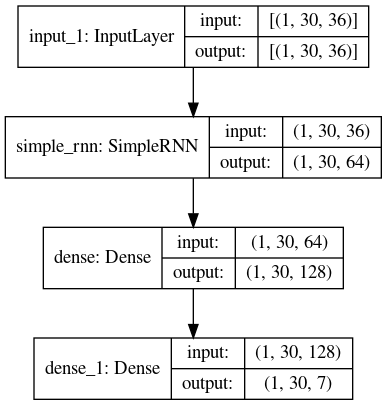

In [9]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [10]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
history = model.fit(X_train, y_train, validation_split=0.33, batch_size=1, epochs=10, shuffle=False)

Epoch 1/10
693/693 [==============================] - 7s 10ms/step - loss: 1.1272 - accuracy: 0.5271 - val_loss: 1.9369 - val_accuracy: 0.4088
Epoch 2/10
693/693 [==============================] - 6s 9ms/step - loss: 0.9646 - accuracy: 0.6571 - val_loss: 2.0419 - val_accuracy: 0.4410
Epoch 3/10
693/693 [==============================] - 7s 10ms/step - loss: 0.9117 - accuracy: 0.6805 - val_loss: 2.0241 - val_accuracy: 0.4748
Epoch 4/10
693/693 [==============================] - 7s 10ms/step - loss: 0.8735 - accuracy: 0.6946 - val_loss: 2.0368 - val_accuracy: 0.5131
Epoch 5/10
693/693 [==============================] - 6s 9ms/step - loss: 0.8466 - accuracy: 0.7037 - val_loss: 2.0632 - val_accuracy: 0.5410
Epoch 6/10
693/693 [==============================] - 6s 9ms/step - loss: 0.8253 - accuracy: 0.7103 - val_loss: 2.0704 - val_accuracy: 0.5795
Epoch 7/10
693/693 [==============================] - 6s 9ms/step - loss: 0.7939 - accuracy: 0.7212 - val_loss: 2.1431 - val_accuracy: 0.5953
Epo

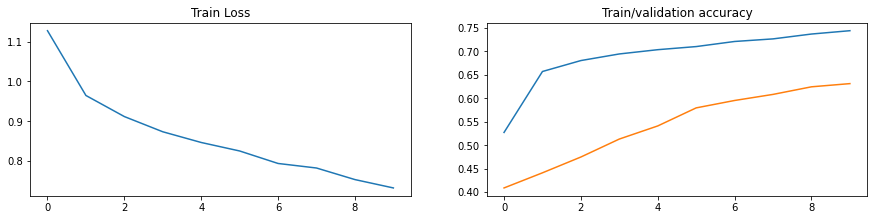

In [12]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title("Train Loss")
plt.plot(history.history['loss'])
plt.subplot(222)
plt.title("Train/validation accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

## LSTM

In [20]:
def get_model():
    return K.Sequential([
        K.layers.InputLayer((30, 36), batch_size=1),
        K.layers.LSTM(64, return_sequences=True),
        K.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(l2=1e-3)),
        K.layers.Dense(7, activation='softmax')
    ])

In [21]:
model = get_model()

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 30, 64)               25856     
_________________________________________________________________
dense_4 (Dense)              (1, 30, 128)              8320      
_________________________________________________________________
dense_5 (Dense)              (1, 30, 7)                903       
Total params: 35,079
Trainable params: 35,079
Non-trainable params: 0
_________________________________________________________________


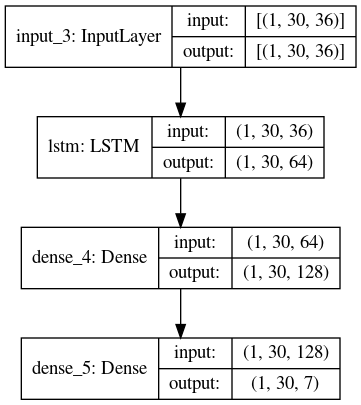

In [23]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [24]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
history = model.fit(X_train, y_train, validation_split=0.33, batch_size=1, epochs=10, shuffle=False)

Epoch 1/10
693/693 [==============================] - 10s 15ms/step - loss: 1.1190 - accuracy: 0.5328 - val_loss: 1.8262 - val_accuracy: 0.4755
Epoch 2/10
693/693 [==============================] - 9s 13ms/step - loss: 0.9286 - accuracy: 0.6538 - val_loss: 1.8394 - val_accuracy: 0.5133
Epoch 3/10
693/693 [==============================] - 10s 14ms/step - loss: 0.8597 - accuracy: 0.6850 - val_loss: 1.9351 - val_accuracy: 0.5327
Epoch 4/10
693/693 [==============================] - 9s 14ms/step - loss: 0.8246 - accuracy: 0.7048 - val_loss: 1.9891 - val_accuracy: 0.5615
Epoch 5/10
693/693 [==============================] - 9s 13ms/step - loss: 0.7829 - accuracy: 0.7173 - val_loss: 1.9708 - val_accuracy: 0.6304
Epoch 6/10
693/693 [==============================] - 9s 12ms/step - loss: 0.7389 - accuracy: 0.7386 - val_loss: 2.0342 - val_accuracy: 0.6412
Epoch 7/10
693/693 [==============================] - 9s 13ms/step - loss: 0.7034 - accuracy: 0.7518 - val_loss: 2.0933 - val_accuracy: 0.64

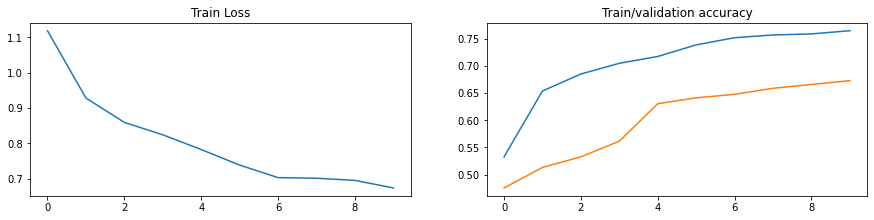

In [26]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title("Train Loss")
plt.plot(history.history['loss'])
plt.subplot(222)
plt.title("Train/validation accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

## GRU

In [13]:
def get_model():
    return K.Sequential([
        K.layers.InputLayer((30, 36), batch_size=1),
        K.layers.GRU(64, return_sequences=True),
        K.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(l2=1e-3)),
        K.layers.Dense(7, activation='softmax')
    ])

In [14]:
model = get_model()

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (1, 30, 64)               19584     
_________________________________________________________________
dense_2 (Dense)              (1, 30, 128)              8320      
_________________________________________________________________
dense_3 (Dense)              (1, 30, 7)                903       
Total params: 28,807
Trainable params: 28,807
Non-trainable params: 0
_________________________________________________________________


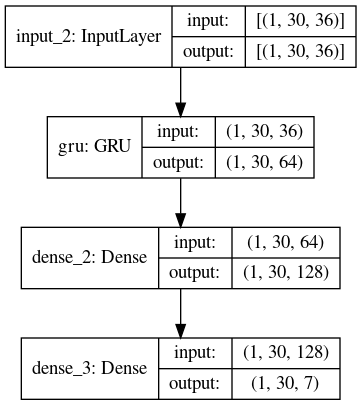

In [16]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [17]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
history = model.fit(X_train, y_train, validation_split=0.33, batch_size=1, epochs=10, shuffle=False)

Epoch 1/10
693/693 [==============================] - 12s 18ms/step - loss: 1.0764 - accuracy: 0.5711 - val_loss: 2.2293 - val_accuracy: 0.4212
Epoch 2/10
693/693 [==============================] - 11s 15ms/step - loss: 0.9327 - accuracy: 0.6691 - val_loss: 2.1268 - val_accuracy: 0.4393
Epoch 3/10
693/693 [==============================] - 9s 13ms/step - loss: 0.8638 - accuracy: 0.7026 - val_loss: 2.0631 - val_accuracy: 0.4760
Epoch 4/10
693/693 [==============================] - 10s 14ms/step - loss: 0.8100 - accuracy: 0.7198 - val_loss: 2.0198 - val_accuracy: 0.5622
Epoch 5/10
693/693 [==============================] - 10s 14ms/step - loss: 0.7638 - accuracy: 0.7299 - val_loss: 2.0217 - val_accuracy: 0.6048
Epoch 6/10
693/693 [==============================] - 9s 13ms/step - loss: 0.7322 - accuracy: 0.7395 - val_loss: 2.0462 - val_accuracy: 0.6317
Epoch 7/10
693/693 [==============================] - 10s 14ms/step - loss: 0.6956 - accuracy: 0.7576 - val_loss: 2.0657 - val_accuracy: 0

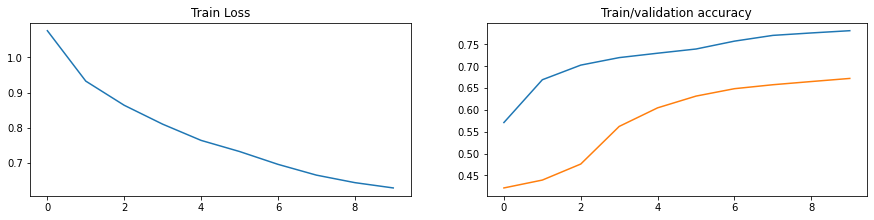

In [19]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title("Train Loss")
plt.plot(history.history['loss'])
plt.subplot(222)
plt.title("Train/validation accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])